In [3]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras 
from keras.layers import Conv2D , MaxPooling2D ,Dropout , Flatten , Dense ,BatchNormalization ,Concatenate ,Input 
from keras.models import Sequential ,Model
from sklearn.model_selection import train_test_split
import os
from PIL import Image
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.optimizers import AdamW
from keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report ,confusion_matrix
from sklearn.utils import class_weight
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from collections import Counter
from keras import regularizers
from keras.callbacks import ReduceLROnPlateau

In [4]:
metadata = pd.read_csv('/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_metadata.csv')
metadata.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [5]:
metadata.count()

lesion_id       10015
image_id        10015
dx              10015
dx_type         10015
age              9958
sex             10015
localization    10015
dtype: int64

In [6]:
metadata.isna().sum()

lesion_id        0
image_id         0
dx               0
dx_type          0
age             57
sex              0
localization     0
dtype: int64

In [7]:
metadata['age'] = metadata['age'].fillna(metadata['age'].mean()) 
metadata.isna().sum()

lesion_id       0
image_id        0
dx              0
dx_type         0
age             0
sex             0
localization    0
dtype: int64

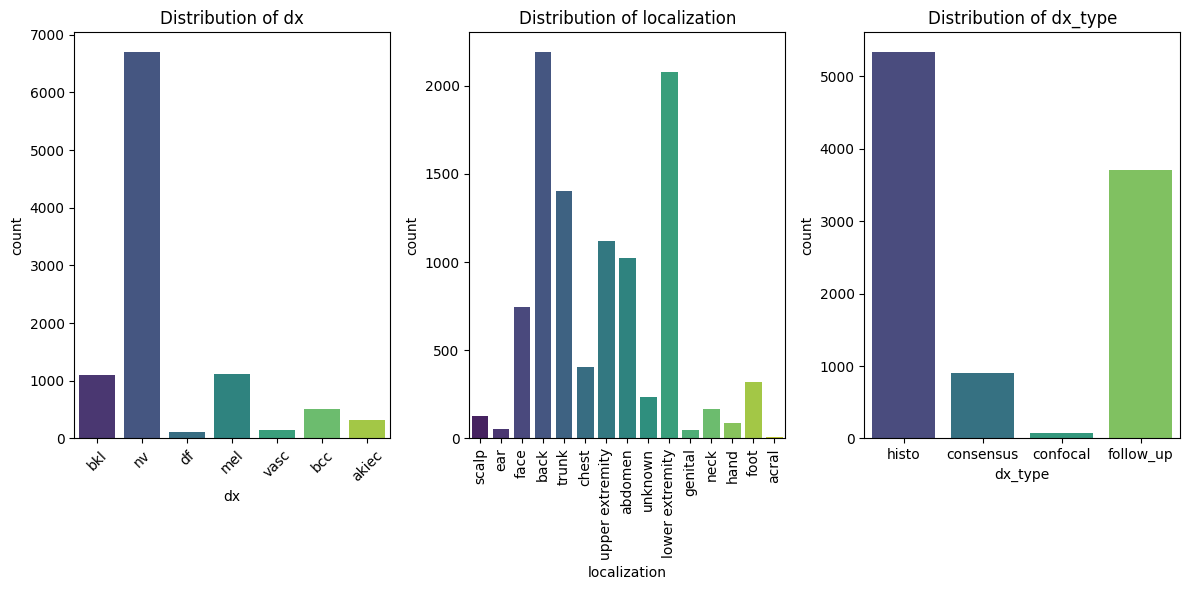

In [8]:
plt.figure(figsize=(12, 6))
plt.subplot(1,3,1)
sns.countplot(data=metadata , x='dx' ,palette='viridis')
plt.title('Distribution of dx')
plt.xticks(rotation=45)


plt.subplot(1,3,2)
sns.countplot(data=metadata,x='localization' ,palette='viridis')
plt.title('Distribution of localization')
plt.xticks(rotation=90)

plt.subplot(1,3,3)
sns.countplot(data=metadata , x = 'dx_type' , palette='viridis')
plt.title('Distribution of dx_type')

plt.tight_layout()
plt.show()


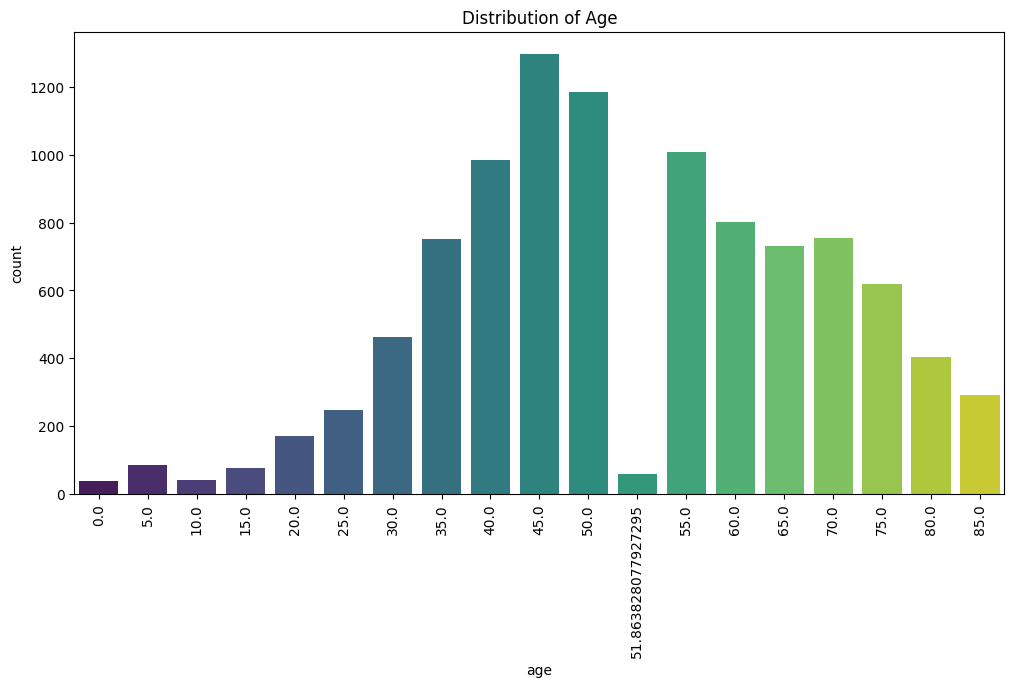

In [9]:
plt.figure(figsize=(12,6))
sns.countplot(data=metadata ,x='age',palette='viridis')
plt.title('Distribution of Age')
plt.xticks(rotation=90)

plt.show()


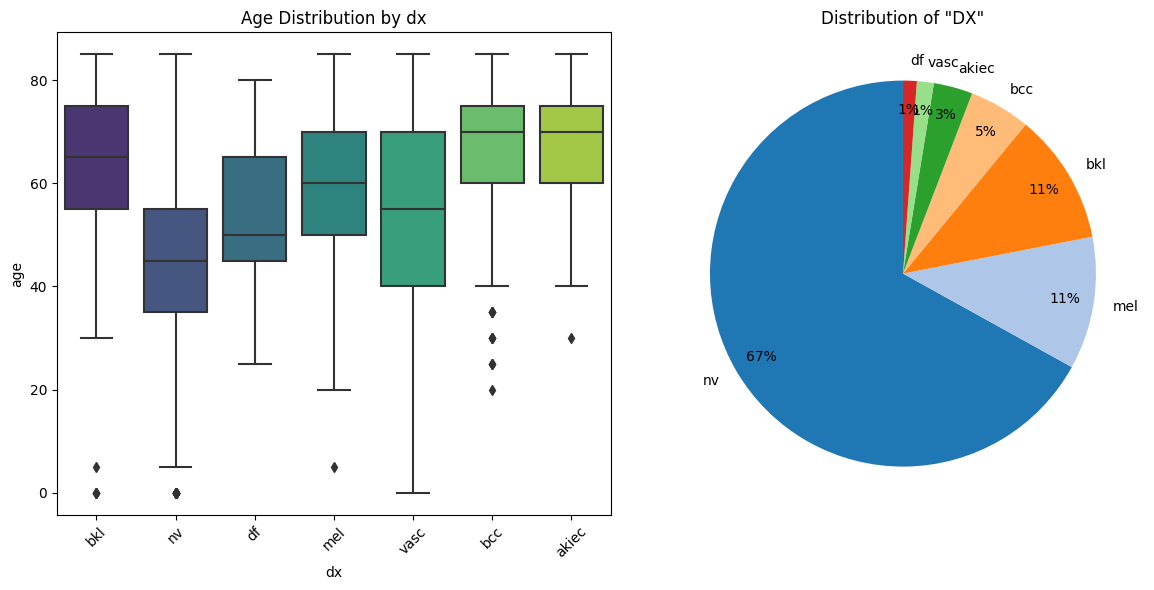

In [10]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
sns.boxplot(data=metadata, x='dx', y='age', palette='viridis')
plt.title('Age Distribution by dx')
plt.xticks(rotation=45)


plt.subplot(1,2,2)
metadata['dx'].value_counts().plot.pie(
    autopct='%1.f%%', 
    startangle=90,      
    colors=sns.color_palette('tab20', len(metadata['dx'].unique())),
    pctdistance=0.85    
)
plt.title('Distribution of "DX"')
plt.ylabel('')

plt.tight_layout()
plt.show()

In [11]:
metadata['sex'].value_counts()

sex
male       5406
female     4552
unknown      57
Name: count, dtype: int64

In [12]:
def col_values_unique (df):
    for col in df :
        if df[col].dtypes=='object':
            print(col ,f':' ,df[col].unique())
col_values_unique(metadata)

lesion_id : ['HAM_0000118' 'HAM_0002730' 'HAM_0001466' ... 'HAM_0005579' 'HAM_0001576'
 'HAM_0002867']
image_id : ['ISIC_0027419' 'ISIC_0025030' 'ISIC_0026769' ... 'ISIC_0033536'
 'ISIC_0032854' 'ISIC_0032258']
dx : ['bkl' 'nv' 'df' 'mel' 'vasc' 'bcc' 'akiec']
dx_type : ['histo' 'consensus' 'confocal' 'follow_up']
sex : ['male' 'female' 'unknown']
localization : ['scalp' 'ear' 'face' 'back' 'trunk' 'chest' 'upper extremity' 'abdomen'
 'unknown' 'lower extremity' 'genital' 'neck' 'hand' 'foot' 'acral']


In [13]:
metadata['dx'].value_counts()

dx
nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: count, dtype: int64

In [14]:
metadata_features = metadata[['age','dx_type' ,'sex','localization']].copy()
# feature encoding
metadata_features = pd.get_dummies(metadata_features , columns=['dx_type' ,'sex','localization'],drop_first=True,dtype=int)
# age normalization
metadata_features['age'] = metadata_features['age']/metadata_features['age'].max()

x_metadata = np.array(metadata_features)
# x_metadata
metadata_features.head()

,age,dx_type_consensus,dx_type_follow_up,dx_type_histo,sex_male,sex_unknown,localization_acral,localization_back,localization_chest,localization_ear,localization_face,localization_foot,localization_genital,localization_hand,localization_lower extremity,localization_neck,localization_scalp,localization_trunk,localization_unknown,localization_upper extremity
0,0.941176,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1,0.941176,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2,0.941176,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
3,0.941176,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
4,0.882353,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0


In [15]:
label_mapping = {
    "bkl": 0,
    "nv": 1,
    "df": 2,
    "mel": 3,
    "vasc": 4,
    "bcc": 5,
    "akiec": 6
}

In [16]:
def load_image(image_id  , image_folder):
    image_path = os.path.join(image_folder , f'{image_id}.jpg')
    return Image.open(image_path)

image_folder1 = '/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_1'
image_folder2 = '/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_2'

# Initialize ImageDataGenerator for data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Count the number of samples in each class
class_counts = metadata['dx'].value_counts()
threshold = class_counts.mean()  # Adjust based on your needs

# Define classes to boost
boost_classes = ['df', 'vasc','akiec','bcc']  # List of classes to augment more

# Create a list to hold new images and their corresponding labels
new_images = []
new_labels = []

# Loop through the metadata to augment images for minority classes
for idx, row in metadata.iterrows():
    dx = row['dx']
    image_id = row['image_id']
    
    # Check if the class is a minority class
    if class_counts[dx] < threshold or dx in boost_classes:  # Augment if below threshold or in boost_classes
        # Load the original image
        try:
            image = load_image(image_id, image_folder1)
        except FileNotFoundError:
            image = load_image(image_id, image_folder2)

        # Prepare the image for augmentation
        image = image.resize((128, 128))
        image_array = img_to_array(image) / 255.0  # Normalize

        # Determine how many augmented images to create
        num_augmented = 5 if dx in boost_classes else 3  # More for specific classes

        # Generate augmented images
        for _ in range(num_augmented):
            augmented_image = datagen.random_transform(image_array)
            new_images.append(augmented_image)
            new_labels.append(dx)  # Use original label instead of mapping



# Create a new DataFrame for the augmented images with original labels
augmented_df = pd.DataFrame({
    'image_id': ['aug_' + str(i) for i in range(len(new_labels))],
    'dx': new_labels
})

# Combine original metadata with augmented metadata
updated_metadata = pd.concat([metadata, augmented_df], ignore_index=True)

x_image = np.array(new_images)
y = np.array(new_labels)
y_encoded = pd.get_dummies(y , dtype=int).values


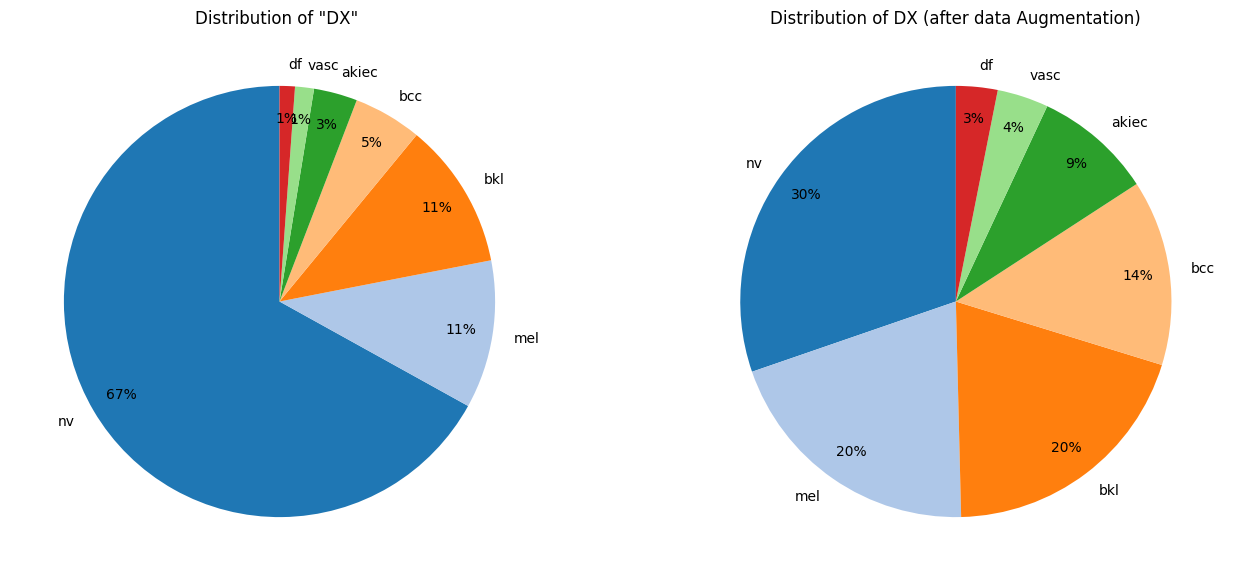

In [17]:
# Visualize the updated distribution of "dx"
plt.figure(figsize=(16, 7))
plt.subplot(1,2,1)
metadata['dx'].value_counts().plot.pie(
    autopct='%1.f%%', 
    startangle=90,      
    colors=sns.color_palette('tab20', len(metadata['dx'].unique())),
    pctdistance=0.85    
)
plt.title('Distribution of "DX" ')
plt.ylabel('')



plt.subplot(1, 2, 2)
updated_metadata['dx'].value_counts().plot.pie(
    autopct='%1.f%%', 
    startangle=90,      
    colors=sns.color_palette('tab20', len(updated_metadata['dx'].unique())),
    pctdistance=0.85    
)
plt.title('Distribution of DX (after data Augmentation)')
plt.ylabel('')

plt.show()

In [18]:
len(y)

12126

In [19]:
y = np.array(new_labels)

# One-hot encode the labels
y_encoded = pd.get_dummies(y, dtype=int)

# Display the original labels and their corresponding one-hot encoded values
print("Original labels and their one-hot encoded values:")
for original in np.unique(y):  # Using unique to avoid duplicates
    print(f'{original}: {y_encoded[original].values}')

# Display the full one-hot encoded DataFrame
print("\nFull one-hot encoded DataFrame:")
print(y_encoded)


Original labels and their one-hot encoded values:
akiec: [0 0 0 ... 0 0 0]
bcc: [0 0 0 ... 0 0 0]
bkl: [1 1 1 ... 0 0 0]
df: [0 0 0 ... 0 0 0]
mel: [0 0 0 ... 1 1 1]
vasc: [0 0 0 ... 0 0 0]

Full one-hot encoded DataFrame:
       akiec  bcc  bkl  df  mel  vasc
0          0    0    1   0    0     0
1          0    0    1   0    0     0
2          0    0    1   0    0     0
3          0    0    1   0    0     0
4          0    0    1   0    0     0
...      ...  ...  ...  ..  ...   ...
12121      1    0    0   0    0     0
12122      1    0    0   0    0     0
12123      0    0    0   0    1     0
12124      0    0    0   0    1     0
12125      0    0    0   0    1     0

[12126 rows x 6 columns]


In [20]:
classes = ["Benign keratosis-like lesions 'bkl'" , "Melanocytic nevi 'nv'" ,"Dermatofibroma 'df'",
           "Melanoma 'mel'","Vascular lesions 'vasc'","Basal cell carcinoma 'bcc'" ,
           'Actinic keratoses and intraepithelial carcinoma "akiec"']

In [21]:
print(y_encoded)

       akiec  bcc  bkl  df  mel  vasc
0          0    0    1   0    0     0
1          0    0    1   0    0     0
2          0    0    1   0    0     0
3          0    0    1   0    0     0
4          0    0    1   0    0     0
...      ...  ...  ...  ..  ...   ...
12121      1    0    0   0    0     0
12122      1    0    0   0    0     0
12123      0    0    0   0    1     0
12124      0    0    0   0    1     0
12125      0    0    0   0    1     0

[12126 rows x 6 columns]


In [22]:
updated_metadata.dx.value_counts()

dx
nv       6705
mel      4452
bkl      4396
bcc      3084
akiec    1962
vasc      852
df        690
Name: count, dtype: int64

In [23]:
classes[np.argmax(y_encoded.iloc[0])]

"Dermatofibroma 'df'"

In [24]:
def show_samples(i):
    plt.imshow(x_image[i])
    plt.xlabel(classes[np.argmax(y_encoded.iloc[i])])
    plt.show()

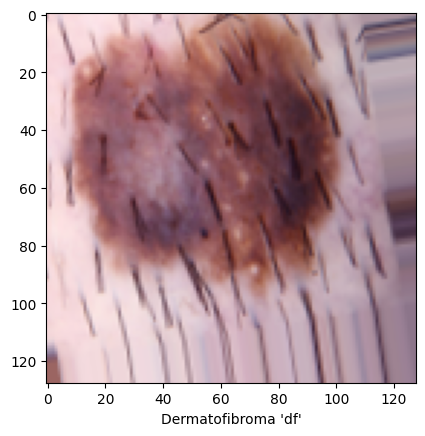

In [25]:
show_samples(802)

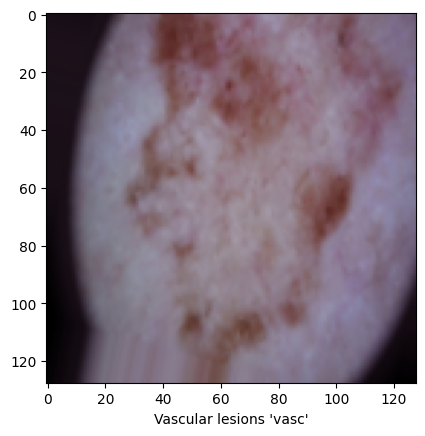

In [26]:
show_samples(6000)

In [27]:
len(x_image),len(y_encoded)
x_image.shape,y_encoded.shape

((12126, 128, 128, 3), (12126, 6))

In [28]:
y_encoded = np.array(y_encoded)
x_train,x_test,y_train,y_test = train_test_split(x_image , y_encoded ,stratify=y,test_size=.2 ,random_state=42)
print(y_train[400])
y_train = np.argmax(y_train ,axis=1)
y_test = np.argmax(y_test , axis=1)
len(x_train),len(y_train)


[1 0 0 0 0 0]


(9700, 9700)

In [29]:
y_train

array([2, 2, 4, ..., 2, 0, 3])

In [30]:
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3))),
model.add(BatchNormalization()),
model.add(Conv2D(32, (3, 3), activation='relu',kernel_regularizer= regularizers.l2(0.01))),
model.add(BatchNormalization()),
model.add(MaxPooling2D(pool_size=(2, 2))) ,
model.add(Dropout(.2)),

model.add(Conv2D(64, (3, 3), activation='relu' ,kernel_regularizer= regularizers.l2(0.01))),
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu' ,kernel_regularizer= regularizers.l2(0.01))),
model.add(BatchNormalization()),
model.add(MaxPooling2D(pool_size=(2, 2))) ,
model.add(Dropout(.3)),

model.add(Conv2D(128, (3, 3), activation='relu' ,kernel_regularizer=regularizers.l2(0.01))),
model.add(BatchNormalization()),
model.add(Conv2D(128, (3, 3), activation='relu' ,kernel_regularizer=regularizers.l2(0.01))),
model.add(BatchNormalization()),
model.add(MaxPooling2D(pool_size=(2, 2))),
model.add(Dropout(.4)),
          
model.add(Conv2D(256 ,(3,3) ,activation='relu' , kernel_regularizer=regularizers.l2(0.01))),
model.add(BatchNormalization()),
model.add(Conv2D(256 ,(3,3) ,activation='relu' , kernel_regularizer=regularizers.l2(0.01))),
model.add(BatchNormalization()),
model.add(MaxPooling2D(2,2)),
model.add(Dropout(.6)),
model.add(Flatten()),

model.add(Dense(6, activation='softmax'))      

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',  # Metric to monitor
    factor=0.5,          # Reduce the learning rate by half
    patience=3,          # Number of epochs to wait before reducing LR
    min_lr=1e-6          # Minimum learning rate
)


early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,  # Stop after 5 epochs with no improvement
    restore_best_weights=True
)

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [31]:
history = model.fit(x_train , y_train ,
          validation_data=(x_test,y_test), epochs=100 , callbacks=[lr_scheduler,early_stopping])

Epoch 1/100


I0000 00:00:1727236898.151513     112 service.cc:145] XLA service 0x790bcc04a610 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1727236898.151583     112 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


  5/304 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - accuracy: 0.2046 - loss: 12.5343  

I0000 00:00:1727236912.997462     112 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.3672 - loss: 10.0365

I0000 00:00:1727236933.563649     109 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion_5', 68 bytes spill stores, 68 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion_6', 68 bytes spill stores, 68 bytes spill loads



304/304 ━━━━━━━━━━━━━━━━━━━━ 46s 83ms/step - accuracy: 0.3672 - loss: 10.0325 - val_accuracy: 0.2733 - val_loss: 6.5344 - learning_rate: 0.0010
Epoch 2/100
304/304 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - accuracy: 0.4174 - loss: 5.7853 - val_accuracy: 0.3875 - val_loss: 3.8064 - learning_rate: 0.0010
Epoch 3/100
304/304 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - accuracy: 0.4216 - loss: 3.9556 - val_accuracy: 0.4213 - val_loss: 2.7751 - learning_rate: 0.0010
Epoch 4/100
304/304 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - accuracy: 0.4363 - loss: 2.7589 - val_accuracy: 0.4093 - val_loss: 2.3141 - learning_rate: 0.0010
Epoch 5/100
304/304 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - accuracy: 0.4279 - loss: 2.5604 - val_accuracy: 0.4229 - val_loss: 2.6313 - learning_rate: 0.0010
Epoch 6/100
304/304 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - accuracy: 0.4429 - loss: 2.3234 - val_accuracy: 0.4027 - val_loss: 2.3483 - learning_rate: 0.0010
Epoch 7/100
304/304 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - accuracy: 0.4462 - loss: 2.338

In [32]:
model.evaluate(x_test,y_test)

76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8451 - loss: 0.5925


[0.6129042506217957, 0.8351195454597473]

In [33]:
model.save('my_model.h5')
os.listdir('/kaggle/working/')

['.virtual_documents', 'my_model.h5']

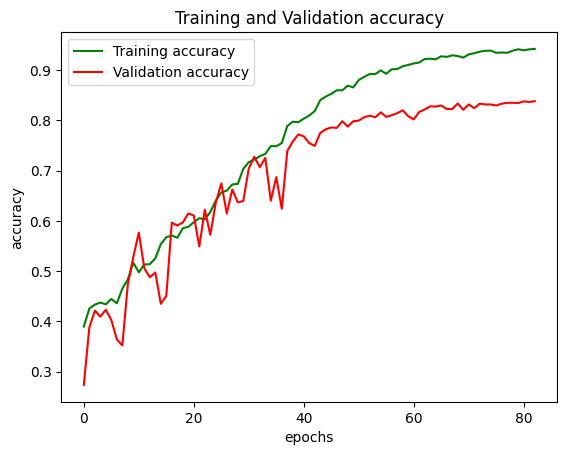

In [34]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(0,len(acc))

plt.plot(epochs , acc , 'g',label='Training accuracy')
plt.plot(epochs , val_acc , 'r' , label='Validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

In [35]:
y_test[2000:2015]

array([1, 1, 2, 2, 2, 2, 0, 4, 1, 5, 0, 2, 1, 4, 4])

In [36]:
y_pred = model.predict(x_test)
y_predict = np.argmax(y_pred , axis=1)
y_predict[2000:2015]

76/76 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step


array([1, 1, 2, 2, 2, 2, 0, 2, 1, 5, 0, 2, 1, 2, 4])

In [37]:
print(classification_report(y_test,y_predict))

              precision    recall  f1-score   support

           0       0.81      0.74      0.77       327
           1       0.87      0.90      0.88       514
           2       0.79      0.83      0.81       660
           3       0.87      0.81      0.84       115
           4       0.83      0.81      0.82       668
           5       0.99      0.93      0.96       142

    accuracy                           0.84      2426
   macro avg       0.86      0.84      0.85      2426
weighted avg       0.84      0.84      0.83      2426



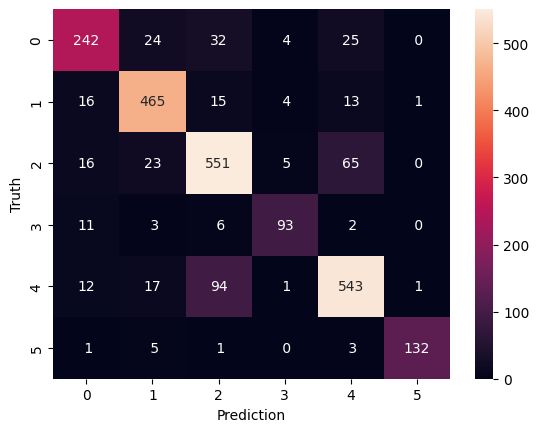

In [38]:
cm = confusion_matrix(y_test,y_predict)
sns.heatmap(cm , annot=True , fmt='2d')
plt.xlabel('Prediction')
plt.ylabel('Truth')
plt.show()

**Manual Prediction**

In [39]:
def actual_image(i1):
    plt.imshow(x_test[i1])
    plt.xlabel(f'Truth : {classes[y_test[i1]]}' ) 

In [40]:
def image_classify(i2): 
    plt.imshow(x_test[i2])
    plt.xlabel(f'Predict : {classes[y_predict[i2]]}' ) 

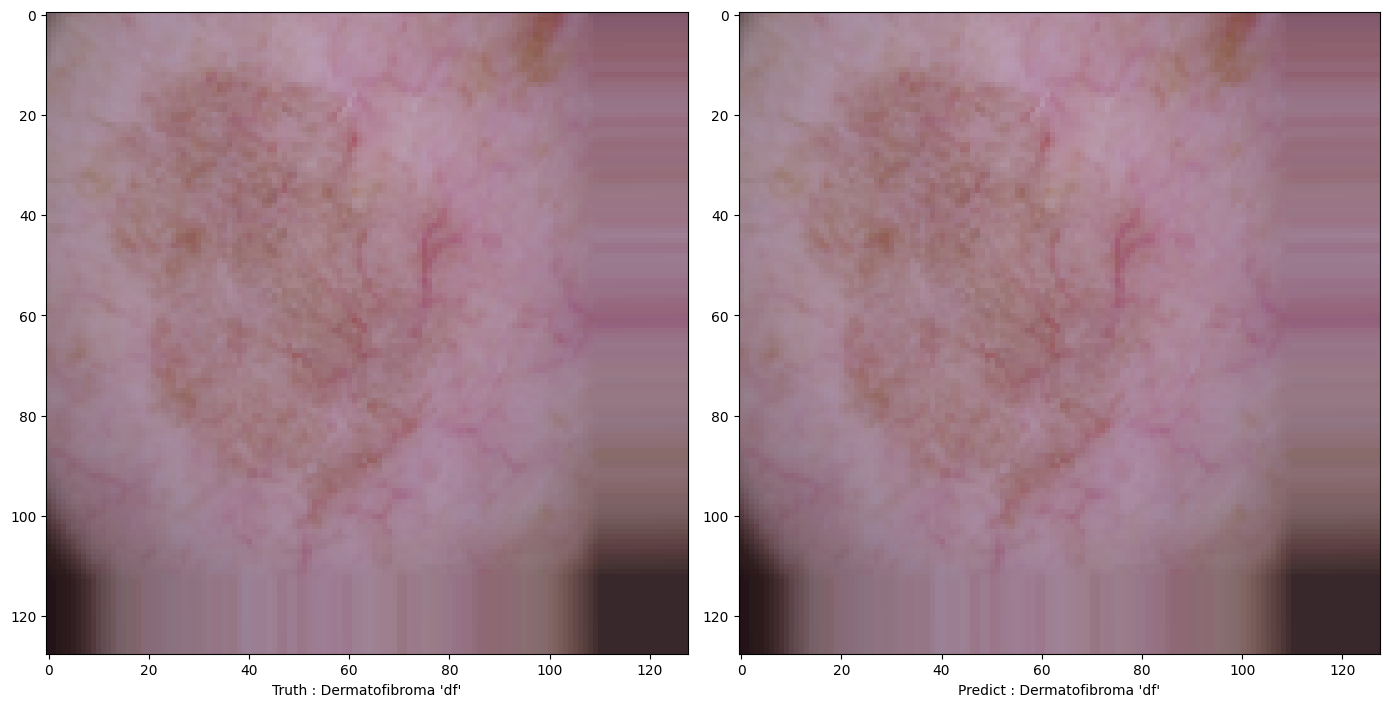

In [109]:
plt.figure(figsize=(14,7))
plt.subplot(1,2,1)
actual_image(2003)


plt.subplot(1,2,2)
image_classify(2003)

plt.tight_layout()
plt.show()

In [110]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
from PIL import Image
import requests
from io import BytesIO
import os

# Load the trained model
model = load_model('my_model.h5')

# Define your classes
classes = [
    "Benign keratosis-like lesions 'bkl'",
    "Melanocytic nevi 'nv'",
    "Dermatofibroma 'df'",
    "Melanoma 'mel'",
    "Vascular lesions 'vasc'",
    "Basal cell carcinoma 'bcc'",
    "Actinic keratoses and intraepithelial carcinoma 'akiec'"
]

# Preprocess the image
def preprocess_image(img):
    img = img.resize((128, 128))  # Resize to match your model's input size
    img_array = np.array(img) / 255.0  # Normalize the image
    return np.expand_dims(img_array, axis=0)  # Add batch dimension

# Function to classify the image from a URL or local path
def classify_image(image_path):
    try:
        # Check if the path is a URL or a local file
        if image_path.startswith('http://') or image_path.startswith('https://'):
            response = requests.get(image_path)
            img = Image.open(BytesIO(response.content))
        else:
            img = Image.open(image_path)  # Local file path
        
        img_preprocessed = preprocess_image(img)
        prediction = model.predict(img_preprocessed)
        predicted_class = classes[np.argmax(prediction)]
        return f"Predicted Class: {predicted_class}"
    except Exception as e:
        return f"Error: {e}"

# Interactive input for the image URL or local path
image_path = input("Enter the image URL or local path for classification: ")  # User inputs the image URL or local path
result = classify_image(image_path)
print(result)    

Enter the image URL or local path for classification:  /kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_1/ISIC_0028198.jpg


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 622ms/step
Predicted Class: Vascular lesions 'vasc'
